# Explore teams dataset

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import model_selection
import xgboost as xgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-17 19:35:36.165 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [3]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"

In [4]:
try:
    train_home_team_statistics_df = pd.read_csv(RAW_DATA_DIR / "train_home_team_statistics_df.csv", index_col=0)
    train_away_team_statistics_df = pd.read_csv(RAW_DATA_DIR / "train_away_team_statistics_df.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [5]:
# 'LEAGUE' et 'TEAM_NAME' not included
home_teams = train_home_team_statistics_df.iloc[:,2:]
away_teams = train_away_team_statistics_df.iloc[:,2:]

# Rename
home_teams.columns = 'HOME_' + home_teams.columns
away_teams.columns = 'AWAY_' + away_teams.columns

train_data_teams = pd.concat([home_teams, away_teams], join='inner', axis=1)
train_data_teams = train_data_teams.apply(replace_null_values)
train_scores = train_scores.loc[train_data_teams.index]

print(train_data_teams.shape) 

(12303, 280)


In [6]:
train_data_teams.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,HOME_TEAM_YELLOWCARDS_season_sum,HOME_TEAM_REDCARDS_season_sum,HOME_TEAM_OFFSIDES_season_sum,HOME_TEAM_ATTACKS_season_sum,HOME_TEAM_PENALTIES_season_sum,HOME_TEAM_SUBSTITUTIONS_season_sum,HOME_TEAM_BALL_SAFE_season_sum,HOME_TEAM_DANGEROUS_ATTACKS_season_sum,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GOALS_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_average,HOME_TEAM_SHOTS_INSIDEBOX_season_average,HOME_TEAM_SHOTS_OFF_TARGET_season_average,HOME_TEAM_SHOTS_ON_TARGET_season_average,HOME_TEAM_SHOTS_OUTSIDEBOX_season_average,HOME_TEAM_PASSES_season_average,HOME_TEAM_SUCCESSFUL_PASSES_season_average,HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average,HOME_TEAM_SAVES_season_average,HOME_TEAM_CORNERS_season_average,HOME_TEAM_BALL_POSSESSION_season_average,HOME_TEAM_FOULS_season_average,HOME_TEAM_YELLOWCARDS_season_average,HOME_TEAM_REDCARDS_season_average,HOME_TEAM_OFFSIDES_season_average,HOME_TEAM_ATTACKS_season_average,HOME_TEAM_PENALTIES_season_average,HOME_TEAM_SUBSTITUTIONS_season_average,HOME_TEAM_BALL_SAFE_season_average,HOME_TEAM_DANGEROUS_ATTACKS_season_average,HOME_TEAM_INJURIES_season_average,HOME_TEAM_GOALS_season_average,HOME_TEAM_GAME_WON_season_average,HOME_TEAM_GAME_DRAW_season_average,HOME_TEAM_GAME_LOST_season_average,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,HOME_TEAM_PASSES_season_std,HOME_TEAM_SUCCESSFUL_PASSES_season_std,HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std,HOME_TEAM_SAVES_season_std,HOME_TEAM_CORNERS_season_std,HOME_TEAM_BALL_POSSESSION_season_std,HOME_TEAM_FOULS_season_std,HOME_TEAM_YELLOWCARDS_season_std,HOME_TEAM_REDCARDS_season_std,HOME_TEAM_OFFSIDES_season_std,HOME_TEAM_ATTACKS_season_std,HOME_TEAM_PENALTIES_season_std,HOME_TEAM_SUBSTITUTIONS_season_std,HOME_TEAM_BALL_SAFE_season_std,HOME_TEAM_DANGEROUS_ATTACKS_season_std,HOME_TEAM_INJURIES_season_std,HOME_TEAM_GOALS_season_std,HOME_TEAM_SHOTS_TOTAL_5_last_match_sum,HOME_TEAM_SHOTS_INSIDEBOX_5_last_match_sum,HOME_TEAM_SHOTS_OFF_TARGET_5_last_match_sum,HOME_TEAM_SHOTS_ON_TARGET_5_last_match_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum,HOME_TEAM_PASSES_5_last_match_sum,HOME_TEAM_SUCCESSFUL_PASSES_5_last_match_sum,HOME_TEAM_SAVES_5_last_match_sum,HOME_TEAM_CORNERS_5_last_match_sum,HOME_TEAM_FOULS_5_last_match_sum,HOME_TEAM_YELLOWCARDS_5_last_match_sum,HOME_TEAM_REDCARDS_5_last_match_sum,HOME_TEAM_OFFSIDES_5_last_match_sum,HOME_TEAM_ATTACKS_5_last_match_sum,HOME_TEAM_PENALTIES_5_last_match_sum,HOME_TEAM_SUBSTITUTIONS_5_last_match_sum,HOME_TEAM_BALL_SAFE_5_last_match_sum,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_sum,HOME_TEAM_INJURIES_5_last_match_sum,HOME_TEAM_GOALS_5_last_match_sum,HOME_TEAM_GAME_WON_5_last_match_sum,HOME_TEAM_GAME_DRAW_5_last_match_sum,HOME_TEAM_GAME_LOST_5_last_match_sum,HOME_TEAM_SHOTS_TOTAL_5_last_match_average,HOME_TEAM_SHOTS_INSIDEBOX_5_last_match_average,HOME_TEAM_SHOTS_OFF_TARGET_5_last_match_average,HOME_TEAM_SHOTS_ON_TARGET_5_last_match_average,HOME_TEAM_SHOTS_OUTSIDEBOX_5_last_match_average,HOME_TEAM_PASSES_5_last_match_average,HOME_TEAM_SUCCESSFUL_PASSES_5_last_match_average,HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,HOME_TEAM_SAVES_5_last_match_average,HOME_TEAM_CORNERS_5_last_match_average,HOME_TEAM_BALL_POSSESSION_5_last_match_average,HOME_TEAM_FOULS_5_last_match_average,HOME_TEAM_YELLOWCARDS_5_last_match_average,HOME_TEAM_REDCARDS_5_last_match_average,HOME_TEAM_OFFSIDES_5_last_match_average,HOME_TEAM_ATTACKS_5_last_match_average,HOME_TEAM_PENALTI

---
---

In [7]:
train_data = train_data_teams.copy()
train_data = train_data.fillna(train_data.select_dtypes(include=['number']).median())

In [8]:
print_perc_nans(train_data, threshold=0)

No columns have a percentage of NaN values above the threshold.


### Feature Engineering

In [9]:
### DIFFERENCES
# Get the list of HOME and AWAY columns
home_columns = [col for col in train_data.columns if col.startswith('HOME_TEAM_')]
away_columns = [col for col in train_data.columns if col.startswith('AWAY_TEAM_')]

# Ensure there is a corresponding AWAY column for each HOME column
common_columns = [(home, home.replace('HOME_TEAM_', 'AWAY_TEAM_')) for home in home_columns if home.replace('HOME_TEAM_', 'AWAY_TEAM_') in away_columns]

# Add difference features
for home_col, away_col in common_columns:
    diff_col_name = home_col.replace('HOME_TEAM_', 'DIFF_')  # Name of the new column
    train_data[diff_col_name] = train_data[home_col] - train_data[away_col]

# Delete initial features
cols_to_drop = home_columns + away_columns
train_data.drop(columns=cols_to_drop, inplace=True)


In [10]:
train_data.shape

(12303, 140)

In [11]:
train_data.head()

,DIFF_SHOTS_TOTAL_season_sum,DIFF_SHOTS_INSIDEBOX_season_sum,DIFF_SHOTS_OFF_TARGET_season_sum,DIFF_SHOTS_ON_TARGET_season_sum,DIFF_SHOTS_OUTSIDEBOX_season_sum,DIFF_PASSES_season_sum,DIFF_SUCCESSFUL_PASSES_season_sum,DIFF_SAVES_season_sum,DIFF_CORNERS_season_sum,DIFF_FOULS_season_sum,DIFF_YELLOWCARDS_season_sum,DIFF_REDCARDS_season_sum,DIFF_OFFSIDES_season_sum,DIFF_ATTACKS_season_sum,DIFF_PENALTIES_season_sum,DIFF_SUBSTITUTIONS_season_sum,DIFF_BALL_SAFE_season_sum,DIFF_DANGEROUS_ATTACKS_season_sum,DIFF_INJURIES_season_sum,DIFF_GOALS_season_sum,DIFF_GAME_WON_season_sum,DIFF_GAME_DRAW_season_sum,DIFF_GAME_LOST_season_sum,DIFF_SHOTS_TOTAL_season_average,DIFF_SHOTS_INSIDEBOX_season_average,DIFF_SHOTS_OFF_TARGET_season_average,DIFF_SHOTS_ON_TARGET_season_average,DIFF_SHOTS_OUTSIDEBOX_season_average,DIFF_PASSES_season_average,DIFF_SUCCESSFUL_PASSES_season_average,DIFF_SUCCESSFUL_PASSES_PERCENTAGE_season_average,DIFF_SAVES_season_average,DIFF_CORNERS_season_average,DIFF_BALL_POSSESSION_season_average,DIFF_FOULS_season_average,DIFF_YELLOWCARDS_season_average,DIFF_REDCARDS_season_average,DIFF_OFFSIDES_season_average,DIFF_ATTACKS_season_average,DIFF_PENALTIES_season_average,DIFF_SUBSTITUTIONS_season_average,DIFF_BALL_SAFE_season_average,DIFF_DANGEROUS_ATTACKS_season_average,DIFF_INJURIES_season_average,DIFF_GOALS_season_average,DIFF_GAME_WON_season_average,DIFF_GAME_DRAW_season_average,DIFF_GAME_LOST_season_average,DIFF_SHOTS_TOTAL_season_std,DIFF_SHOTS_INSIDEBOX_season_std,DIFF_SHOTS_OFF_TARGET_season_std,DIFF_SHOTS_ON_TARGET_season_std,DIFF_SHOTS_OUTSIDEBOX_season_std,DIFF_PASSES_season_std,DIFF_SUCCESSFUL_PASSES_season_std,DIFF_SUCCESSFUL_PASSES_PERCENTAGE_season_std,DIFF_SAVES_season_std,DIFF_CORNERS_season_std,DIFF_BALL_POSSESSION_season_std,DIFF_FOULS_season_std,DIFF_YELLOWCARDS_season_std,DIFF_REDCARDS_season_std,DIFF_OFFSIDES_season_std,DIFF_ATTACKS_season_std,DIFF_PENALTIES_season_std,DIFF_SUBSTITUTIONS_season_std,DIFF_BALL_SAFE_season_std,DIFF_DANGEROUS_ATTACKS_season_std,DIFF_INJURIES_season_std,DIFF_GOALS_season_std,DIFF_SHOTS_TOTAL_5_last_match_sum,DIFF_SHOTS_INSIDEBOX_5_last_match_sum,DIFF_SHOTS_OFF_TARGET_5_last_match_sum,DIFF_SHOTS_ON_TARGET_5_last_match_sum,DIFF_SHOTS_OUTSIDEBOX_5_last_match_sum,DIFF_PASSES_5_last_match_sum,DIFF_SUCCESSFUL_PASSES_5_last_match_sum,DIFF_SAVES_5_last_match_sum,DIFF_CORNERS_5_last_match_sum,DIFF_FOULS_5_last_match_sum,DIFF_YELLOWCARDS_5_last_match_sum,DIFF_REDCARDS_5_last_match_sum,DIFF_OFFSIDES_5_last_match_sum,DIFF_ATTACKS_5_last_match_sum,DIFF_PENALTIES_5_last_match_sum,DIFF_SUBSTITUTIONS_5_last_match_sum,DIFF_BALL_SAFE_5_last_match_sum,DIFF_DANGEROUS_ATTACKS_5_last_match_sum,DIFF_INJURIES_5_last_match_sum,DIFF_GOALS_5_last_match_sum,DIFF_GAME_WON_5_last_match_sum,DIFF_GAME_DRAW_5_last_match_sum,DIFF_GAME_LOST_5_last_match_sum,DIFF_SHOTS_TOTAL_5_last_match_average,DIFF_SHOTS_INSIDEBOX_5_last_match_average,DIFF_SHOTS_OFF_TARGET_5_last_match_average,DIFF_SHOTS_ON_TARGET_5_last_match_average,DIFF_SHOTS_OUTSIDEBOX_5_last_match_average,DIFF_PASSES_5_last_match_average,DIFF_SUCCESSFUL_PASSES_5_last_match_average,DIFF_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_SAVES_5_last_match_average,DIFF_CORNERS_5_last_match_average,DIFF_BALL_POSSESSION_5_last_match_average,DIFF_FOULS_5_last_match_average,DIFF_YELLOWCARDS_5_last_match_average,DIFF_REDCARDS_5_last_match_average,DIFF_OFFSIDES_5_last_match_average,DIFF_ATTACKS_5_last_match_average,DIFF_PENALTIES_5_last_match_average,DIFF_SUBSTITUTIONS_5_last_match_average,DIFF_BALL_SAFE_5_last_match_average,DIFF_DANGEROUS_ATTACKS_5_last_match_average,DIFF_INJURIES_5_last_match_average,DIFF_GOALS_5_last_match_average,DIFF_GAME_WON_5_last_match_average,DIFF_GAME_DRAW_5_last_match_average,DIFF_GAME_LOST_5_last_match_average,DIFF_SHOTS_TOTAL_5_last_match_std,DIFF_SHOTS_INSIDEBOX_5_last_match_std,DIFF_SHOTS_OFF_TARGET_5_last_match_std,DIFF_SHOTS_ON_TARGET_5_last_match_std,DIFF_SHOTS_OUTSIDEBOX_5_last_match_std,DIFF_PASSES_5_last_match_std,DIFF_SUCCESSFUL

In [12]:
# ### MOMENTUM
# # Identify recent DIFF columns (with performance over the last 5 matches)
# recent_diff_cols = [col for col in train_data_teams.columns 
#                     if col.startswith("DIFF_") and "_5_last_match_" in col]

# season_diff_cols = [col for col in train_data_teams.columns 
#                     if col.startswith("DIFF_") and "_season_" in col]

# # Compute momentum features as the difference between recent performance and season performance
# for recent_col in recent_diff_cols:
#     season_col = recent_col.replace("_5_last_match_", "_season_")
#     if season_col in season_diff_cols:
#         momentum_col_name = recent_col.replace("_5_last_match_", "_momentum_")
#         train_data_teams[momentum_col_name] = train_data_teams[recent_col] - train_data_teams[season_col]

# # Delete initial features
# cols_to_drop = recent_diff_cols + season_diff_cols
# train_data_teams.drop(columns=cols_to_drop, inplace=True)

In [13]:
train_data_avg = train_data.loc[:, train_data.columns.str.endswith('_average')]
print(train_data_avg.shape)

train_data_sum = train_data.loc[:, train_data.columns.str.endswith('_sum')]
print(train_data_sum.shape)

train_data_std = train_data.loc[:, train_data.columns.str.endswith('_std')]
print(train_data_std.shape)

(12303, 50)
(12303, 46)
(12303, 44)


In [14]:
train_new_y = train_scores['AWAY_WINS']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [15]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

[0]	train-mlogloss:0.68347	eval-mlogloss:0.68775
[1]	train-mlogloss:0.67451	eval-mlogloss:0.68268
[2]	train-mlogloss:0.66566	eval-mlogloss:0.67753
[3]	train-mlogloss:0.65736	eval-mlogloss:0.67269
[4]	train-mlogloss:0.64921	eval-mlogloss:0.66799
[5]	train-mlogloss:0.64123	eval-mlogloss:0.66358
[6]	train-mlogloss:0.63363	eval-mlogloss:0.65927
[7]	train-mlogloss:0.62641	eval-mlogloss:0.65521
[8]	train-mlogloss:0.61909	eval-mlogloss:0.65167
[9]	train-mlogloss:0.61227	eval-mlogloss:0.64785
[10]	train-mlogloss:0.60577	eval-mlogloss:0.64461
[11]	train-mlogloss:0.59854	eval-mlogloss:0.64116
[12]	train-mlogloss:0.59156	eval-mlogloss:0.63760
[13]	train-mlogloss:0.58566	eval-mlogloss:0.63481
[14]	train-mlogloss:0.57916	eval-mlogloss:0.63189
[15]	train-mlogloss:0.57337	eval-mlogloss:0.62914
[16]	train-mlogloss:0.56740	eval-mlogloss:0.62699
[17]	train-mlogloss:0.56161	eval-mlogloss:0.62431
[18]	train-mlogloss:0.55570	eval-mlogloss:0.62172
[19]	train-mlogloss:0.54982	eval-mlogloss:0.61948
[20]	train

In [16]:
X_test_xgb = xgb.DMatrix(X_test)

target = train_scores.loc[X_test.index].copy()
predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)

0.477

In [17]:
# {feature_name: score}
importance_dict = bst.get_score(importance_type='weight')
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
top_features = [feature for feature, score in sorted_features[:10]]
X_reduced = train_data[top_features]

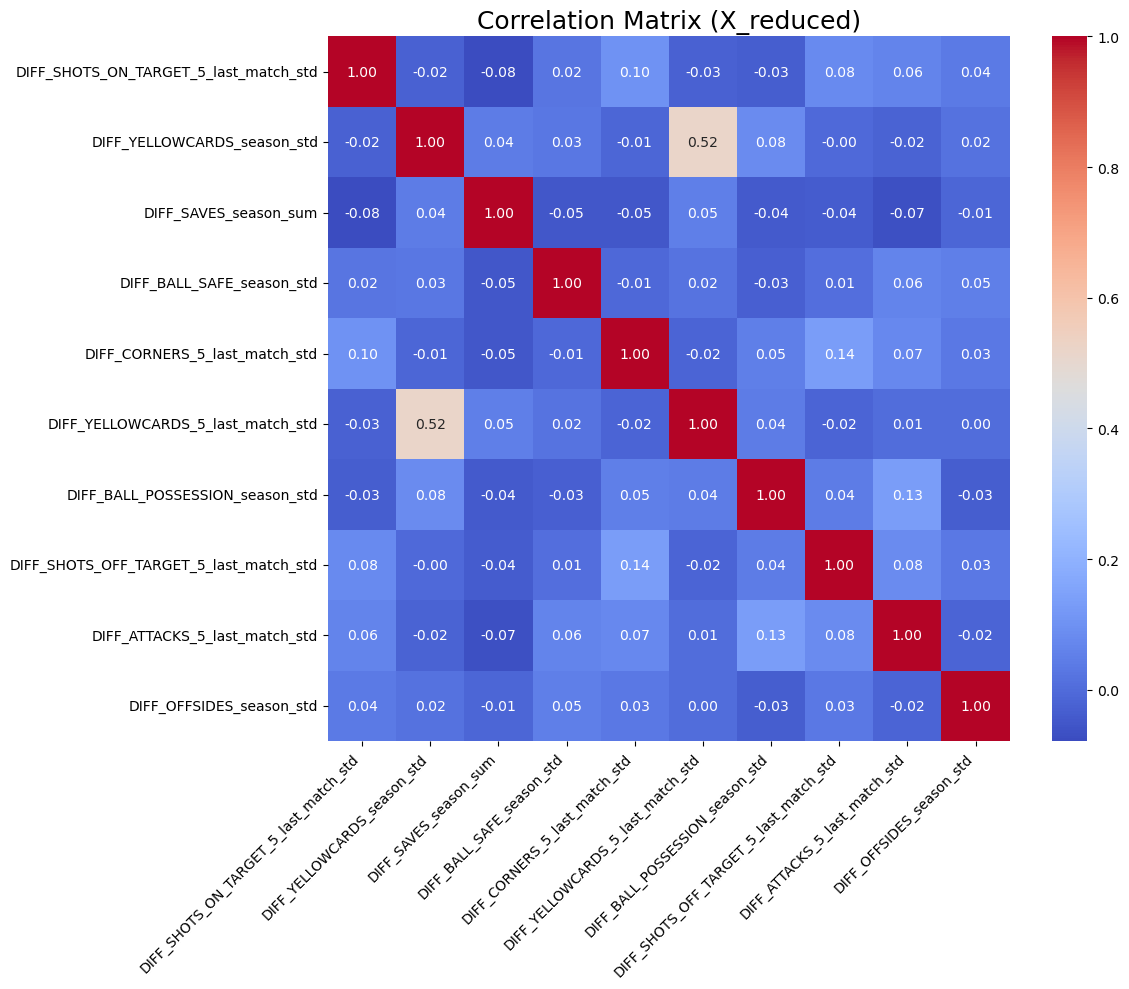

In [18]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

In [19]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns

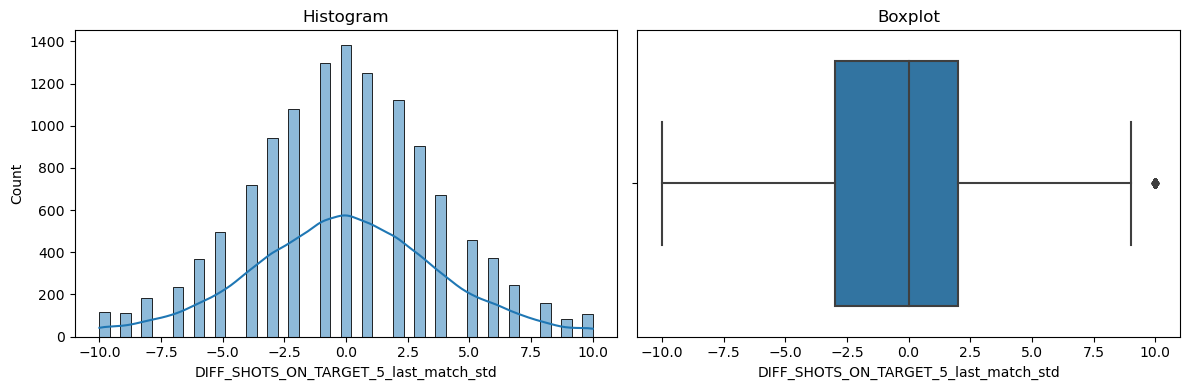

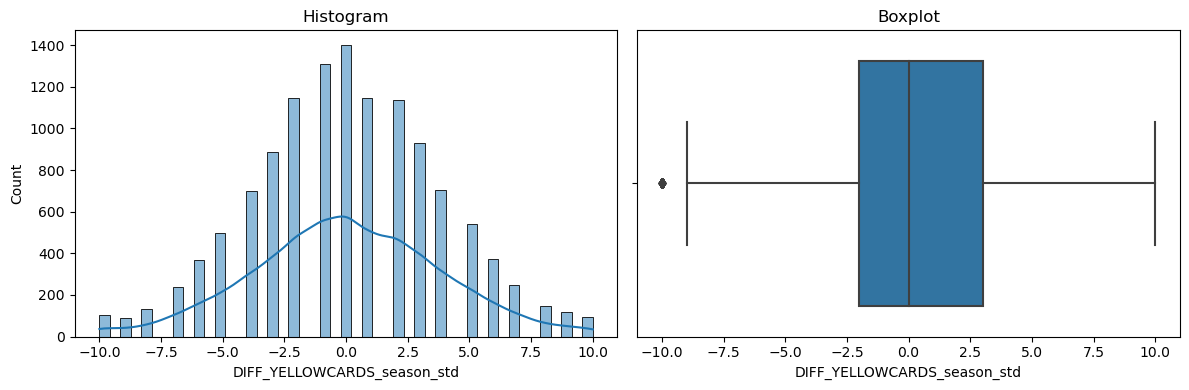

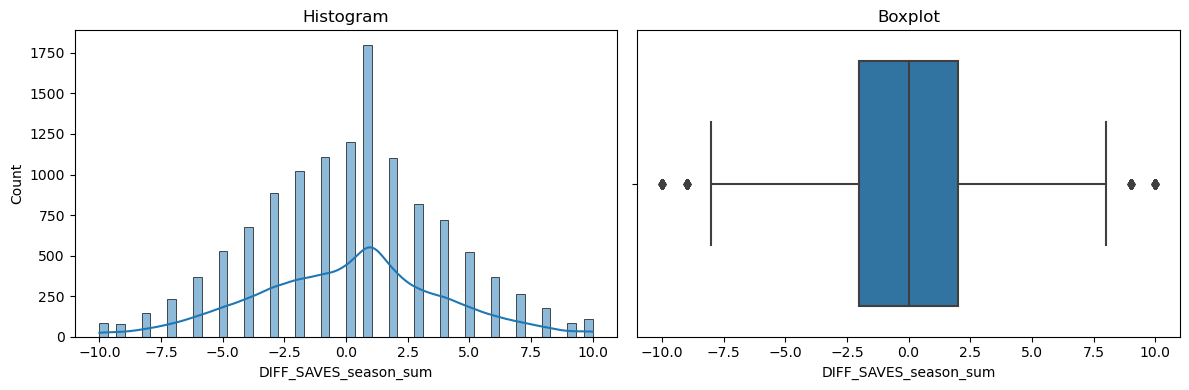

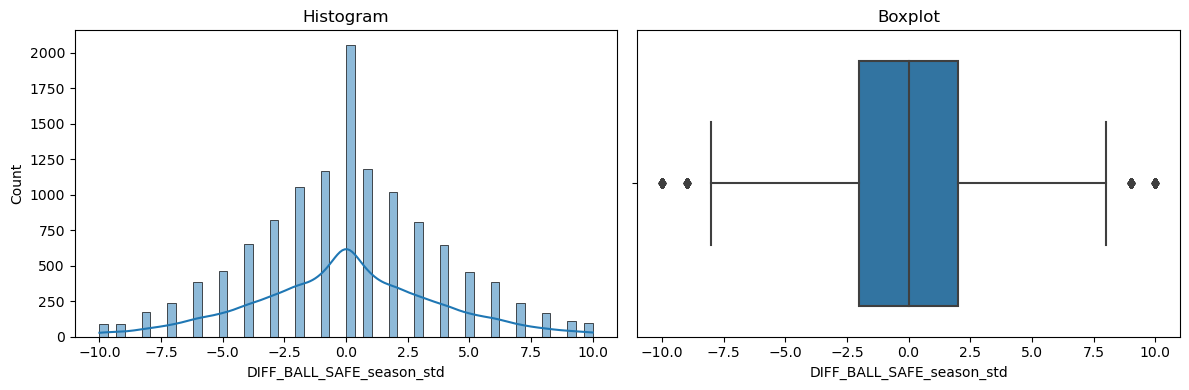

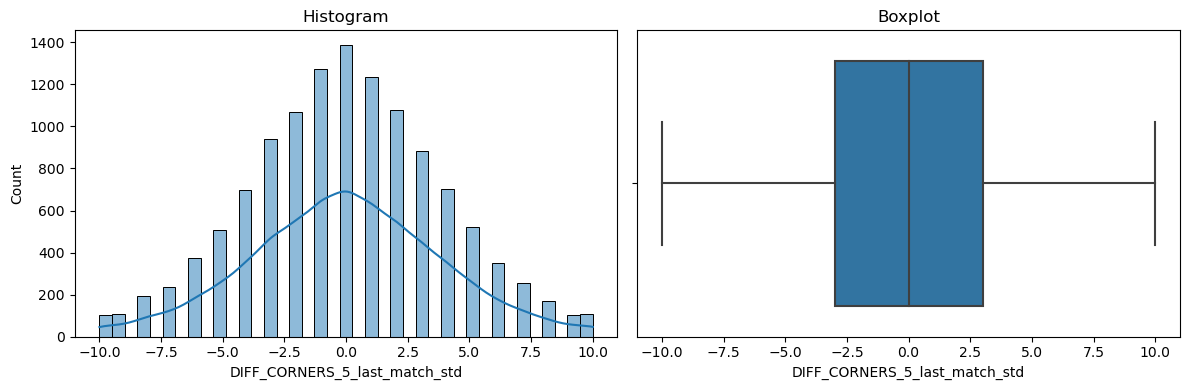

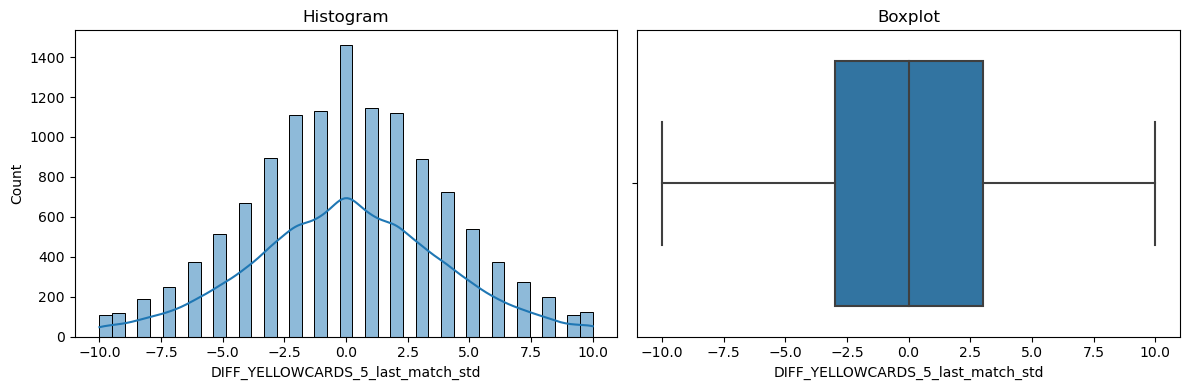

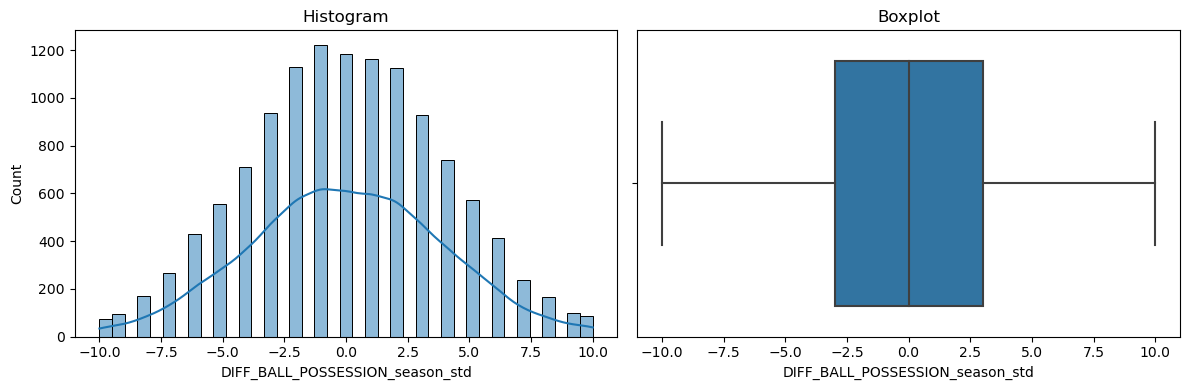

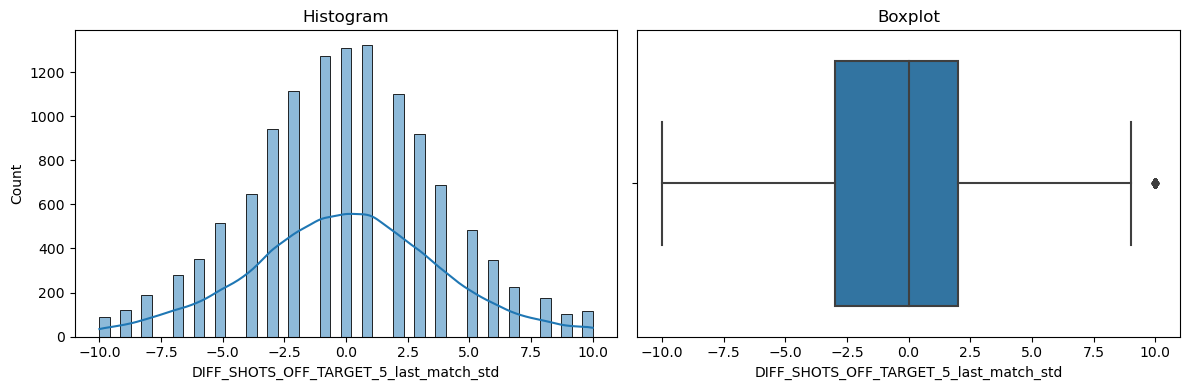

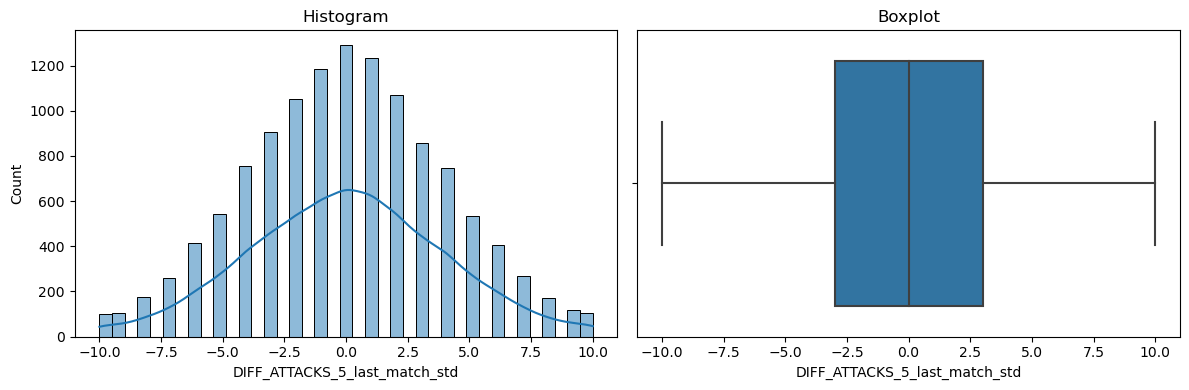

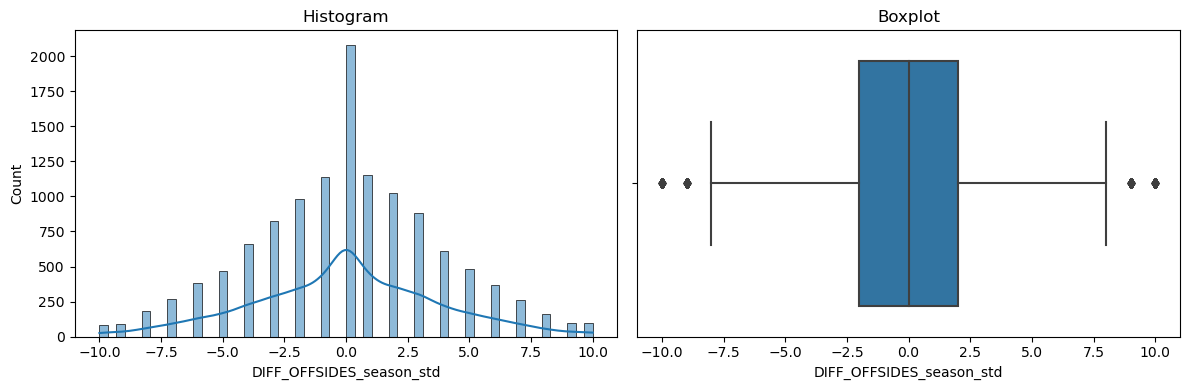

In [20]:
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)

In [21]:
# Store team training data

train_data_path = INTERIM_DATA_DIR / "train_data_teams.csv"
train_data.to_csv(train_data_path, index=True)